In [6]:
import os, sys
os.chdir(os.path.abspath('..'))

In [7]:
import json, pickle
import argparse

import numpy as np
import pandas as pd
import torch
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from torch.utils.tensorboard import SummaryWriter
from tbparse import SummaryReader


In [8]:
%load_ext autoreload
%autoreload 2

from src.vae_models import CVAE
import src.datasets as datasets
import src.utils as utils
import src.preprocess_lib as preprocess_lib
import src.conditioning_lib as conditioning_lib
from src.user_encoding_lib import UserEncoder


In [9]:
config_dir = 'runs/sweep_runs_corrected'
config_file = 'config.json'


In [10]:
df_experiment = pd.DataFrame()
for i, folder in enumerate(os.listdir(os.path.join(config_dir))):
    # Load config file
    with open(os.path.join(config_dir, folder, config_file), 'r') as f: config = json.load(f)
    config_flt = utils.flatten_dict(config)
    config_flt["model_folder"] = folder

    df_config_val = pd.DataFrame(config_flt, index=[i])

    # Load test results
    if not os.path.exists(os.path.join(config_dir, folder, 'test_results.pkl')): df_test = pd.DataFrame()
    else:
        with open(os.path.join(config_dir, folder, 'test_results.pkl'), 'rb') as f: test_results = pickle.load(f)
        test_results_flt = utils.flatten_dict(test_results)
        ##add to dataframe
        df_test = pd.DataFrame([test_results_flt], index=[i])

    df_experiment = pd.concat([df_experiment, pd.concat([df_config_val, df_test], axis=1)], axis=0)


In [11]:
df_experiment.columns

Index(['data_random_seed', 'data_dataset_dir', 'data_dataset_name',
       'data_test_ratio', 'data_val_ratio', 'data_resolution', 'data_pad',
       'data_ampute_params_a', 'data_ampute_params_b',
       'data_subsample_rate_user', 'data_subsample_rate_day',
       'data_scaling_shift', 'data_scaling_zero_id', 'data_scaling_log_space',
       'data_condition_tag_list',
       'data_user_embedding_kwargs_model_kwargs_num_topics',
       'data_user_embedding_kwargs_model_kwargs_num_clusters',
       'data_user_embedding_kwargs_model_kwargs_reduce_dim',
       'data_user_embedding_kwargs_model_kwargs_num_lower_dims',
       'data_user_embedding_kwargs_fit_kwargs_lda_perp_tol',
       'data_user_embedding_kwargs_fit_kwargs_lda_max_iter',
       'data_user_embedding_kwargs_fit_kwargs_lda_batch_size',
       'data_user_embedding_kwargs_fit_kwargs_lda_verbose',
       'data_user_embedding_kwargs_fit_kwargs_lda_learning_method',
       'data_user_embedding_kwargs_fit_kwargs_lda_evaluate_every

In [12]:
##change column names 
df_experiment.rename(columns={  'data_ampute_params_b': 'Availability Rate (b)',
                                'data_condition_tag_list': 'Conditions',
                                'model_distribution_dict_likelihood_dist_type': 'Likelihood Distribution',
                                'data_user_embedding_kwargs_model_kwargs_num_topics': 'Number of LDA Topics',
                                'data_user_embedding_kwargs_model_kwargs_num_clusters': 'Number of LDA Clusters',
                                'model_distribution_dict_likelihood_vocab_size': 'Pattern Dictionary Size',
                                'model_distribution_dict_likelihood_dropout': 'Dropout',
                                'model_distribution_dict_likelihood_num_hidden_layers': 'Number of Layers',
                                'model_distribution_dict_likelihood_num_neurons': 'Number of Neurons',
                                'train_beta': 'Beta',
                                'val_loglikelihood': 'Log-Likelihood (Validation)',
                                'test_loglikelihood': 'Log-Likelihood (Test)',
                                'missing_loglikelihood': 'Log-Likelihood (Missing)',
                              }, inplace=True)

In [13]:
df_experiment["NLL (Test)"] = -df_experiment["Log-Likelihood (Test)"]
df_experiment["NLL (Missing)"] = -df_experiment["Log-Likelihood (Missing)"]
df_experiment["NLL (Validation)"] = -df_experiment["Log-Likelihood (Validation)"]

df_experiment.loc[df_experiment["Conditions"].apply(lambda x: "users" not in x), "Number of LDA Topics"] = 0
df_experiment.loc[df_experiment["Conditions"].apply(lambda x: "users" not in x), "Number of LDA Clusters"] = 0
df_experiment.loc[df_experiment["Likelihood Distribution"] != "dict-gauss", "Pattern Dictionary Size"] = 0

In [14]:
df_experiment["Expected Missing Days"] = np.round(df_experiment['data_ampute_params_a'] / (df_experiment['data_ampute_params_a'] + df_experiment['Availability Rate (b)']) * 365, 1)

In [15]:
df_experiment["Missing Set Size"] = df_experiment.apply(lambda x: np.sum(preprocess_lib.generate_random_enrolments(n=365, a=0.85, b=x["Availability Rate (b)"], size=6830, random_seed=x["data_random_seed"])), axis=1)

df_experiment["Test Set Size"] = (6830*365 - df_experiment["Missing Set Size"])*df_experiment["data_test_ratio"]
df_experiment["Validation Set Size"] = (6830*365 - df_experiment["Missing Set Size"])*df_experiment["data_val_ratio"]
df_experiment["Training Set Size"] = (6830*365 - df_experiment["Missing Set Size"]) - df_experiment["Test Set Size"] - df_experiment["Validation Set Size"]

df_experiment["Test Set Ratio"] = df_experiment["Test Set Size"] / (6830*365)
df_experiment["Validation Set Ratio"] = df_experiment["Validation Set Size"] / (6830*365)
df_experiment["Missing Set Ratio"] = df_experiment["Missing Set Size"] / (6830*365)
df_experiment["Training Set Ratio"] = 1 - df_experiment["Test Set Ratio"] - df_experiment["Validation Set Ratio"] - df_experiment["Missing Set Ratio"]

Mean of enrolments: 80.58
Mean of enrolments: 108.86
Mean of enrolments: 6.10
Mean of enrolments: 53.03
Mean of enrolments: 80.58
Mean of enrolments: 80.58
Mean of enrolments: 28.59
Mean of enrolments: 53.03
Mean of enrolments: 14.88
Mean of enrolments: 53.03
Mean of enrolments: 108.86
Mean of enrolments: 28.59
Mean of enrolments: 108.86
Mean of enrolments: 14.88
Mean of enrolments: 28.59
Mean of enrolments: 6.10
Mean of enrolments: 28.59
Mean of enrolments: 28.59
Mean of enrolments: 80.58
Mean of enrolments: 80.58
Mean of enrolments: 14.88
Mean of enrolments: 108.86
Mean of enrolments: 28.59
Mean of enrolments: 28.59
Mean of enrolments: 28.59
Mean of enrolments: 28.59
Mean of enrolments: 167.70
Mean of enrolments: 167.70
Mean of enrolments: 28.59
Mean of enrolments: 6.10
Mean of enrolments: 108.86
Mean of enrolments: 80.58
Mean of enrolments: 53.03
Mean of enrolments: 6.10
Mean of enrolments: 28.59
Mean of enrolments: 10.06
Mean of enrolments: 108.86
Mean of enrolments: 10.06
Mean of 

## Visualization

### Number of Topics effect

In [16]:
filter_arr =    (df_experiment["Number of LDA Topics"] != None) & \
                (df_experiment["Availability Rate (b)"] == 10) & \
                (df_experiment["Beta"] == 1.0) & \
                (df_experiment["Likelihood Distribution"] != None) & \
                (df_experiment["Number of LDA Clusters"] != None) & \
                (np.isin(df_experiment["Number of LDA Clusters"], [0, 1000])) & \
                (df_experiment["Dropout"] == False) & \
                (df_experiment["Number of Layers"] == 2) & \
                (df_experiment["Number of Neurons"] == 1000) & \
                (df_experiment["Pattern Dictionary Size"] != None) & \
                (np.isin(df_experiment["Pattern Dictionary Size"], [0, 100])) & \
                (df_experiment["data_random_seed"] == 2112) & \
                (df_experiment["model_distribution_dict_likelihood_sigma_lim"] == 1e-4)

In [17]:
relplot_kwargs = {  
                    'data': df_experiment[filter_arr],
                    'x': 'Number of LDA Topics',
                    'style': "Likelihood Distribution",
                    # 'size': 'Log-likelihood - Std (Test)',
                    'alpha': 0.7,
                    # "kind":"line",
                    "sizes": (50,400),
                    # "style_order": (100, 0),
                }

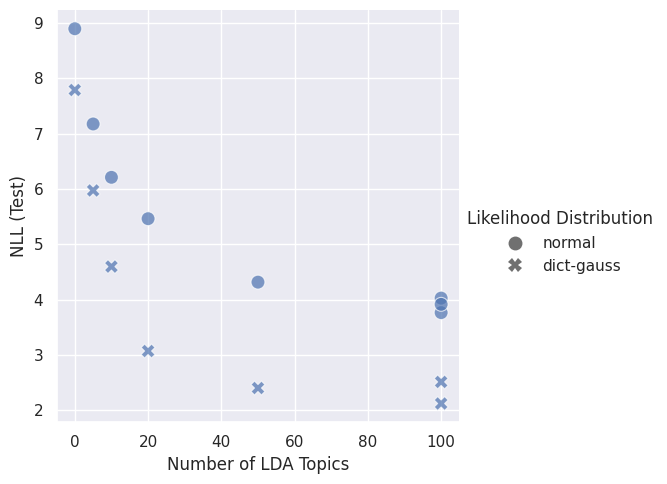

In [18]:
h = sns.relplot(y="NLL (Test)",
                **relplot_kwargs, s=100)
#log scale
# h.set(yscale="log")
# plt.xlim(-10, 110)
# set xlim
plt.show()

### Number of LDA clusters effect

In [19]:
filter_arr =    (df_experiment["Number of LDA Topics"] != None) & \
                (np.isin(df_experiment["Number of LDA Topics"], [0, 5, 20, 50])) & \
                (df_experiment["Availability Rate (b)"] == 10) & \
                (df_experiment["Beta"] == 1.0) & \
                (df_experiment["Likelihood Distribution"] != None) & \
                (df_experiment["Number of LDA Clusters"] != None) & \
                (df_experiment["Dropout"] == False) & \
                (df_experiment["Number of Layers"] == 2) & \
                (df_experiment["Number of Neurons"] == 1000) & \
                (np.isin(df_experiment["Pattern Dictionary Size"], [100])) &\
                (df_experiment["data_random_seed"] == 2112) & \
                (df_experiment["model_distribution_dict_likelihood_sigma_lim"] == 1e-4)

In [20]:
relplot_kwargs = {  
                    'data': df_experiment[filter_arr],
                    'x': "Number of LDA Clusters",
                    'hue': "Number of LDA Topics",
                    # 'size': 'Log-likelihood - Std (Test)',
                    'alpha': 0.7,
                    # "kind":"line",
                    # "sizes": (50, 400),
                }

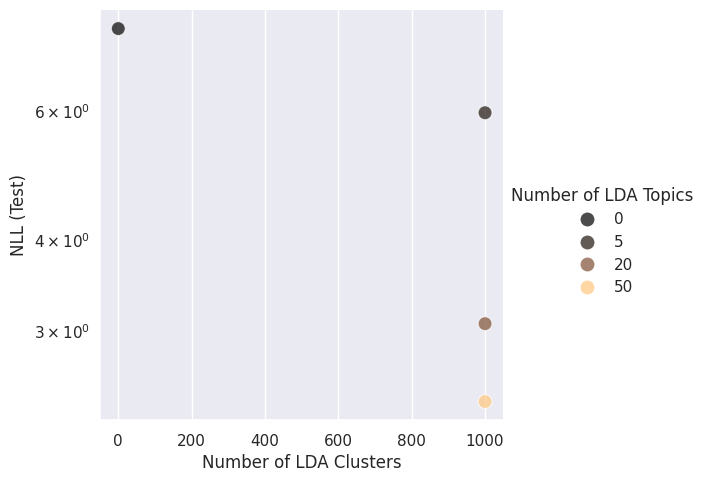

In [21]:
h = sns.relplot(y="NLL (Test)",
                **relplot_kwargs, palette="copper", s=100)
#log scale
h.set(yscale="log")
plt.show()

### Pattern Dictionary size effect

In [22]:
filter_arr =    (df_experiment["Number of LDA Topics"] != None) & \
                (np.isin(df_experiment["Number of LDA Topics"], [0, 100])) & \
                (df_experiment["Availability Rate (b)"] != None) & \
                (np.isin(df_experiment["Availability Rate (b)"], [5, 10, 30])) & \
                (df_experiment["Beta"] == 1.0) & \
                (df_experiment["Likelihood Distribution"] != None) & \
                (df_experiment["Number of LDA Clusters"] != None) & \
                (np.isin(df_experiment["Number of LDA Clusters"], [0, 1000])) & \
                (df_experiment["Dropout"] == False) & \
                (df_experiment["Number of Layers"] == 2) & \
                (df_experiment["Number of Neurons"] == 1000) & \
                (df_experiment["Pattern Dictionary Size"] != None) & \
                (df_experiment["data_random_seed"] != None) & \
                (df_experiment["model_distribution_dict_likelihood_sigma_lim"] == 1e-4)

In [23]:
relplot_kwargs = {  
                    'data': df_experiment[filter_arr],
                    'x': "Pattern Dictionary Size",
                    'style': "Number of LDA Topics",
                    "hue": "Expected Missing Days",
                    # 'size': 'Log-likelihood - Std (Test)',
                    'alpha': 0.7,
                    "kind":"line",
                    # "sizes": (50, 400),
                }

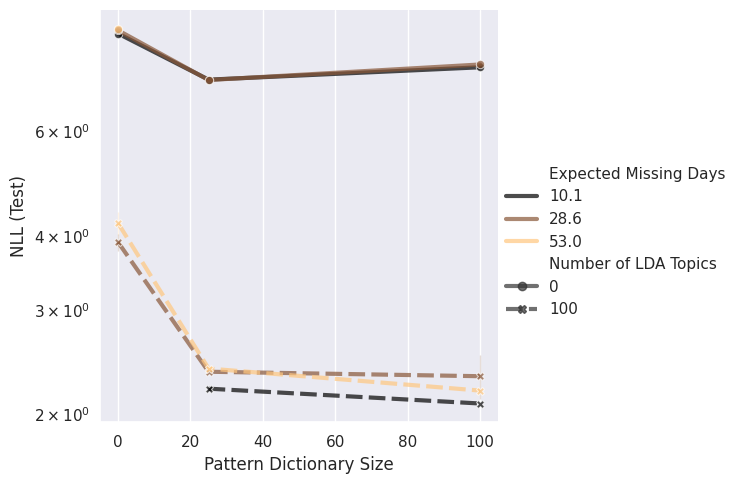

In [24]:
h = sns.relplot(y="NLL (Test)",
                **relplot_kwargs, palette="copper", lw=3, markers=True)
#log scale
h.set(yscale="log")
plt.show()

### Sigma bound effect

In [25]:
filter_arr =    (df_experiment["Number of LDA Topics"] != None) & \
                (np.isin(df_experiment["Number of LDA Topics"], [0, 100])) & \
                (df_experiment["Availability Rate (b)"] == 10) & \
                (df_experiment["Beta"] == 1.0) & \
                (df_experiment["Likelihood Distribution"] != None) & \
                (df_experiment["Number of LDA Clusters"] != None) & \
                (np.isin(df_experiment["Number of LDA Clusters"], [0, 1000])) & \
                (df_experiment["Dropout"] == False) & \
                (df_experiment["Number of Layers"] == 2) & \
                (df_experiment["Number of Neurons"] == 1000) & \
                (df_experiment["Pattern Dictionary Size"] != None) & \
                (np.isin(df_experiment["Pattern Dictionary Size"], [25, 100])) &\
                (df_experiment["model_distribution_dict_likelihood_sigma_lim"] != None)

In [26]:
relplot_kwargs = {  
                    'data': df_experiment[filter_arr],
                    'x': "model_distribution_dict_likelihood_sigma_lim",
                    'hue': "Pattern Dictionary Size",
                    'style': "Number of LDA Topics",
                    # "style": "Amputation Rate (b)",
                    # 'size': 'Log-likelihood - Std (Test)',
                    'alpha': 0.7,
                    "kind":"line",
                    # "sizes": (50, 400),
                }

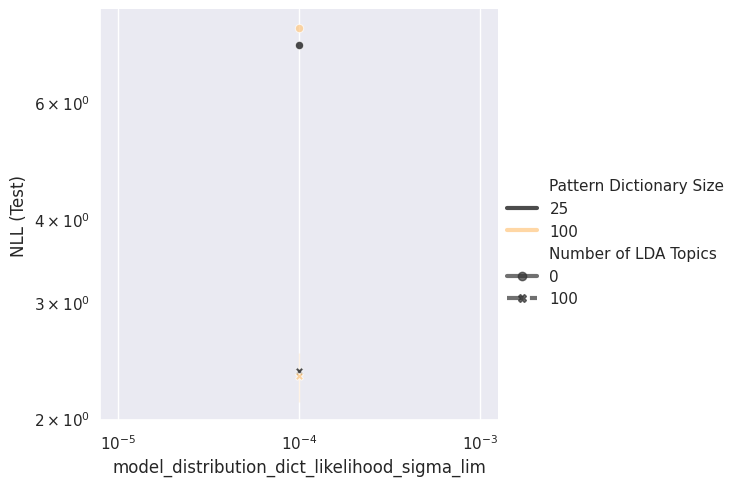

In [27]:
h = sns.relplot(y="NLL (Test)",
                **relplot_kwargs, palette="copper", lw=3, markers=True)
#log scale
h.set(yscale="log")
h.set(xscale="log")
plt.show()

### Amputation rate effect

In [28]:
filter_arr =    (df_experiment["Number of LDA Topics"] != None) & \
                (np.isin(df_experiment["Number of LDA Topics"], [0, 100])) & \
                (df_experiment["Availability Rate (b)"] != 1) & \
                (df_experiment["Beta"] == 1.0) & \
                (df_experiment["Likelihood Distribution"] != None) & \
                (df_experiment["Number of LDA Clusters"] != None) & \
                (np.isin(df_experiment["Number of LDA Clusters"], [0, 1000])) & \
                (df_experiment["Dropout"] != None) & \
                (df_experiment["Number of Layers"] == 2) & \
                (df_experiment["Number of Neurons"] == 1000) & \
                (df_experiment["Pattern Dictionary Size"] != None) & \
                (np.isin(df_experiment["Pattern Dictionary Size"], [0, 25, 100])) &\
                (df_experiment["model_distribution_dict_likelihood_sigma_lim"] == 1e-4)

In [29]:
relplot_kwargs = {  
                    'data': df_experiment[filter_arr],
                    'x': "Availability Rate (b)",
                    'col': "Conditions",
                    'hue': "Pattern Dictionary Size",
                    "style": "Likelihood Distribution",
                    'alpha': 0.7,
                    "kind":"line",
                    # "sizes": (50, 400),
                }

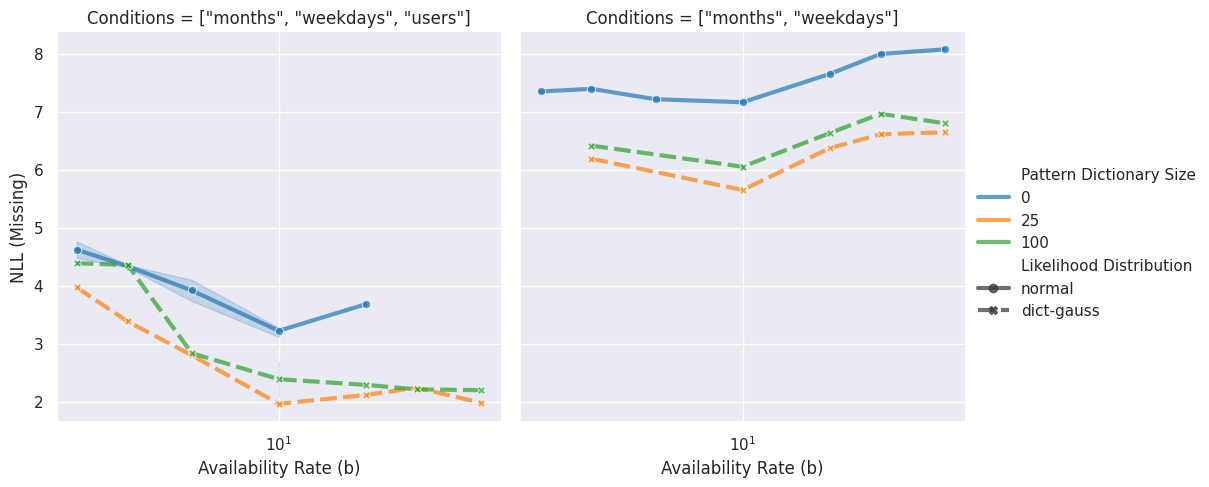

In [30]:
h = sns.relplot(y="NLL (Missing)",
                **relplot_kwargs, palette="tab10", lw=3, markers=True)
#log scale
# h.set(yscale="log")
h.set(xscale="log")
# plt.xlim(30, 175)
plt.show()

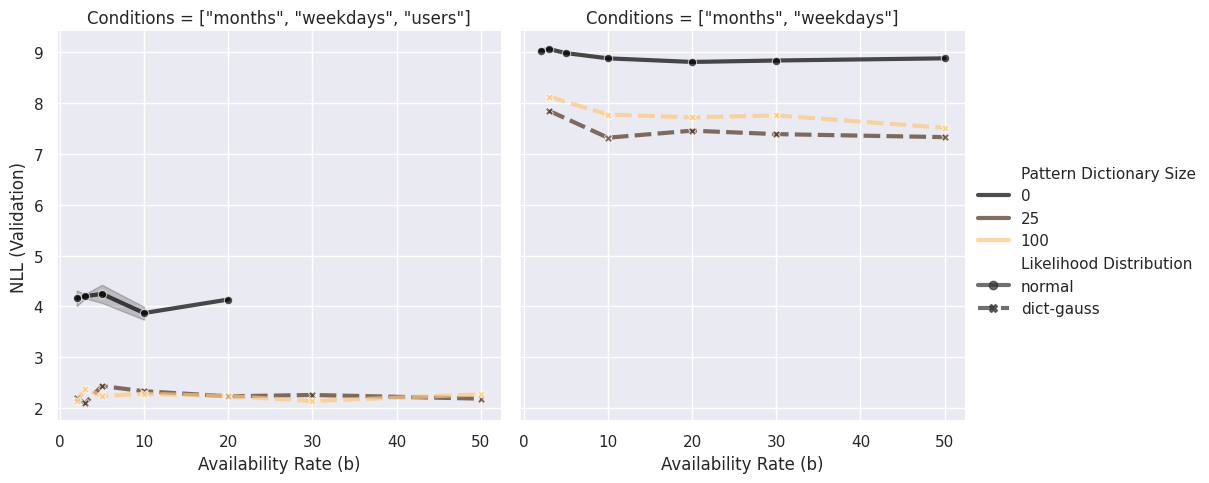

In [31]:
h = sns.relplot(y="NLL (Validation)",
                **relplot_kwargs, palette="copper", lw=3, markers=True)
#log scale
# h.set(yscale="log")
plt.show()

In [58]:
filter_arr =    (df_experiment["Number of LDA Topics"] != None) & \
                (np.isin(df_experiment["Number of LDA Topics"], [0, 100])) & \
                (df_experiment["Availability Rate (b)"] == 50) & \
                (df_experiment["Beta"] == 1.0) & \
                (df_experiment["Likelihood Distribution"] != None) & \
                (df_experiment["Number of LDA Clusters"] != None) & \
                (np.isin(df_experiment["Number of LDA Clusters"], [0, 1000])) & \
                (df_experiment["Dropout"] != None) & \
                (df_experiment["Conditions"] != None) & \
                (df_experiment["Number of Layers"] == 2) & \
                (df_experiment["Number of Neurons"] == 1000) & \
                (df_experiment["Pattern Dictionary Size"] != None) & \
                (np.isin(df_experiment["Pattern Dictionary Size"], [0, 25])) &\
                (df_experiment["model_distribution_dict_likelihood_sigma_lim"] == 1e-4)

In [59]:
monthly_scores = [ scores.tolist() for scores in df_experiment[filter_arr]["val_months"].values.tolist()]

In [60]:
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

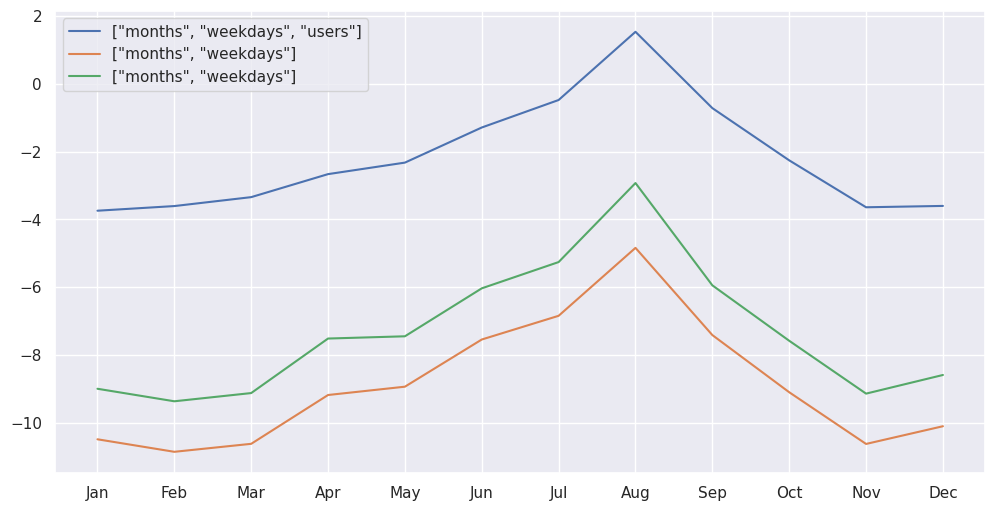

In [131]:
fig, ax = plt.subplots(figsize=(12, 6))
for i, scores in enumerate(monthly_scores):
    plt.plot(scores, label=df_experiment[filter_arr]["Conditions"].values[i])
plt.xticks(range(12), month_names)
plt.legend()
plt.show()

In [103]:
circular_transformer = utils.CircularTransformer(max_conds=12, min_conds=1)

In [116]:
month_encodings = circular_transformer.transform(np.arange(1, 13)[:,None])
month_encodings = np.concatenate([month_encodings, month_encodings[[0],:]], axis=0)

In [135]:
monthly_scores_ = np.array(monthly_scores)
monthly_scores_ = np.concatenate([monthly_scores_, monthly_scores_[:,[0]]], axis=1)


In [157]:
eps = 1e-2
monthly_scores_ = (monthly_scores_ - np.min(monthly_scores_) + eps) / ( np.max(monthly_scores_) - np.min(monthly_scores_) + eps) 


In [164]:
monthly_scores_.max()

1.0

[]

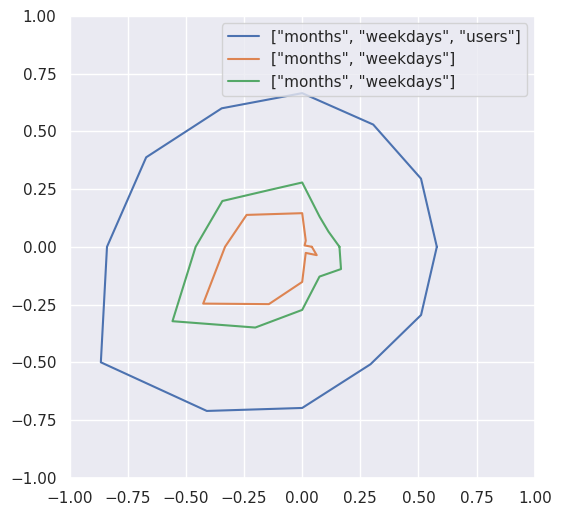

In [166]:
fig, ax = plt.subplots(figsize=(6, 6))

for i, scores in enumerate(monthly_scores_):
    plt.plot(month_encodings[:,0]*scores, month_encodings[:,1]*scores,
              label=df_experiment[filter_arr]["Conditions"].values[i])

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.legend()
plt.plot()

In [91]:
ss_rate = 1
user_scores = [ scores.tolist()[::ss_rate] for scores in df_experiment[filter_arr]["missing_users"].values.tolist()]

In [97]:
sort_idx = np.argsort(user_scores[0])

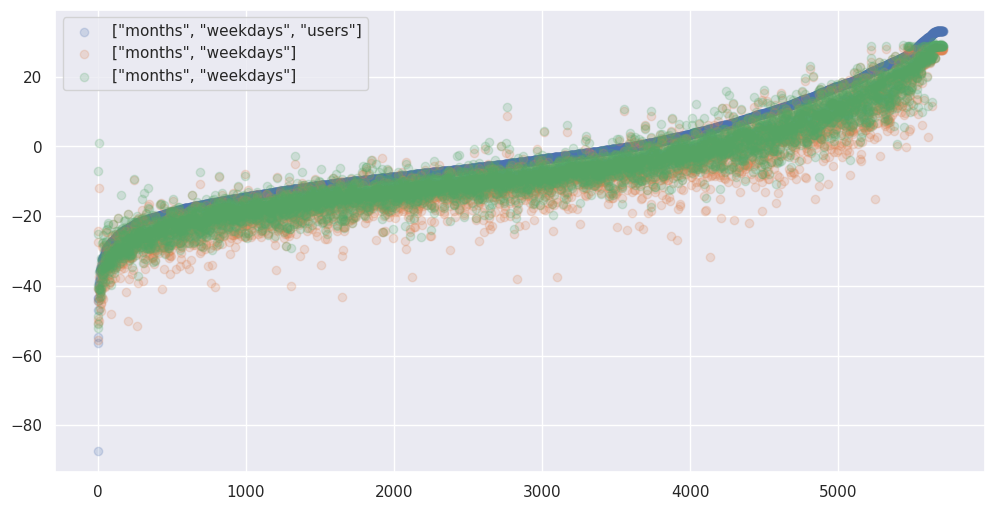

In [98]:
fig, ax = plt.subplots(figsize=(12, 6))
for i, scores in enumerate(user_scores):
    plt.scatter(np.arange(len(scores)), np.array(scores)[[sort_idx]], label=df_experiment[filter_arr]["Conditions"].values[i], alpha=0.2)
plt.legend()
plt.show()